# Project 3 - Algorithem Trading via Machine Learning

Libraries Imported for the Project

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# For best parameters selection
from sklearn.model_selection import GridSearchCV

#Decision Tree Classifier Building in Scikit_learn imports
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report

# Logistic Regression based Libraries
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Visualizaing Decision Tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  


from IPython.display import Image  
import pydotplus


# warning suppressor
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Data Files

In [6]:
nvda_txt = Path('/content/drive/MyDrive/NVDA.txt')

In [7]:
nvda = pd.read_csv(nvda_txt, sep=',',parse_dates = True, infer_datetime_format= True)

Setting up the dataset

In [8]:
class algo_features:
  def __init__(self, dataset, rolling_window=1):
    dataset['Date_time'] = pd.to_datetime(dataset['Date']+' '+dataset['Time'])
    dataset.set_index('Date_time', inplace = True)

    # Price Based Features
    dataset['pct_change'] = 0
    dataset['price_change'] = dataset.Open.diff(periods = rolling_window) # For ML Algo
    dataset['pct_change'] = dataset.Open.pct_change(periods = rolling_window) # For ML Algo
    dataset['pct_change'] = dataset['pct_change'].shift(-1)

    # Volatility based features
    dataset['volatility'] = dataset['pct_change'].rolling(window=30).std() # For ML Algo

    # Volume based features
    dataset['volume'] = dataset['Up'] + dataset['Down']
    dataset['up_volume_ratio'] = dataset['Up'] / dataset['volume'] # For ML Algo
    dataset['down_volume_ratio'] = 1 - dataset['up_volume_ratio']
    dataset['pct_volume'] = dataset['volume'] / dataset.volume.rolling(window = 30).mean() # For ML Algo

    # Moving average based features
    dataset['rolling_30p_high_max'] = dataset['High'].rolling(window = 30).max()
    dataset['rolling_30p_low_min'] = dataset['Low'].rolling(window = 30).min()
    dataset['high_diff_low'] = dataset['rolling_30p_high_max'] - dataset['rolling_30p_low_min']
    dataset['oscillator'] = (dataset['Open'] - dataset['rolling_30p_low_min']) / dataset['high_diff_low'] # For ML Algo
    dataset['moving_avg'] = dataset.Open.rolling(window = 30).mean()
    dataset['slope_moving_avg'] = dataset.moving_avg.pct_change(periods = 1) # For ML Algo
    dataset['pct_change_moving_avg_slope'] = dataset['slope_moving_avg'].pct_change(periods = rolling_window)
    dataset['price_pct_moving_avg'] = dataset['Open'] / dataset['moving_avg'] # For ML Algo
    dataset['moving_correlation_ma_slope'] = dataset['pct_change'].rolling(window = 30).corr(dataset['slope_moving_avg'])
    dataset['moving_corr_slope'] = dataset['moving_correlation_ma_slope'].diff()

    # Target Column
    dataset['target_signal'] = np.where(dataset['pct_change']>=0, 1, 0)

    # Slicing the dataset for Apple
    self.dataset = dataset.dropna()
    self.new_dataset = self.dataset[['Open', 'pct_change', 'price_change', 'volatility', 'up_volume_ratio', 'pct_volume', 'oscillator', 'slope_moving_avg', 'moving_correlation_ma_slope', 'moving_corr_slope', 'price_pct_moving_avg', 'target_signal']]
    #dataset.head(10)
    #return dataset[50:80] # Checking the dataset
  
 


# Decision Tree Machine Learning Algo

In [9]:
class decision_algo:
  def __init__(self, X, y):
    self.X = X
    self.y = y
    split = int(.7 * len(X))
    self.X_train = X[:split - 1]
    self.X_test = X[split:]
    self.y_train = y[:split - 1]
    self.y_test = y[split:]
    
    # parameters to search over with cross-validation using GridSearchCV Algorithem
    grid_params = [
        {
            "max_depth": list(range(2,4)),
            "min_samples_leaf": list(range(2,6)),
        }
    ]

    self.abc = GridSearchCV(DecisionTreeClassifier(), grid_params)
    self.abc.fit(self.X_train, self.y_train)

    #print("Best parameter values: %r\n" % abc.best_params_)

  # Application of decision tree ML Algo

    # Determining the importance features in our dataset
  def importance_features(self, X, y):
    clf = DecisionTreeClassifier()
    clf.fit(X, y)

    feat_importance = clf.tree_.compute_feature_importances(normalize=False) # Creates an array
    feat_importance_new = feat_importance.tolist() # Convert an array to list

    importance = list(zip(feature_cols, feat_importance_new)) # zip both list together
    importance_df = pd.DataFrame(importance, columns = ['Features', 'Importance']) # Convert zipped list to dataframe
    importance_df.sort_values(by = 'Importance', ascending = False, inplace = True)

    print('............................')
    print('Importance Feature')

    importance_df.plot(kind='bar',figsize=(18,5), x = 'Features', y = 'Importance')
 
    plt.show()

    #return importance_df
    
class decision_tree(decision_algo):
  def __init__(self, X, y): 
    a = decision_algo(X, y)
    self.X_train = a.X_train
    self.y_train = a.y_train
    self.X_test = a.X_test
    self.y_test = a.y_test

    # Building Decision Tree Model
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier()

    # Train Decision Tree Classifer
    clf = clf.fit(self.X_train,self.y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(self.X_test)

    # Evaluating Model
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(self.y_test, y_pred))

# Optimizing Decision Tree using max_depths selected using GridSearchCV method  
class decision_tree_dept(decision_algo):
  def __init__(self, X, y):
    b = decision_algo(X, y)
    self.abc = b.abc
    self.X_train = b.X_train
    self.X_test = b.X_test
    self.y_test = b.y_test
    self.y_train = b.y_train
    print('............................')
    print('Optimizing Decision Tree')
    
    # Create Decision Tree classifer object
    print('max_depth: ', self.abc.best_params_['max_depth'])
    print('max_sample_leaf: ', self.abc.best_params_['min_samples_leaf'])
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=self.abc.best_params_['max_depth'], min_samples_leaf= self.abc.best_params_['min_samples_leaf'])

    # Train Decision Tree Classifer
    clf = clf.fit(self.X_train,self.y_train)

    #Predict the response for test dataset
    self.y_pred = clf.predict(self.X_test)

    # Model Accuracy, how often is the classifier correct
    print("Accuracy:",metrics.accuracy_score(self.y_test, self.y_pred))

Running Algorithem for APPLE Stock and Calculating profits

Accuracy: 0.6180441898527005
............................
Optimizing Decision Tree
max_depth:  3
max_sample_leaf:  2
Accuracy: 0.7019230769230769
............................
Importance Feature


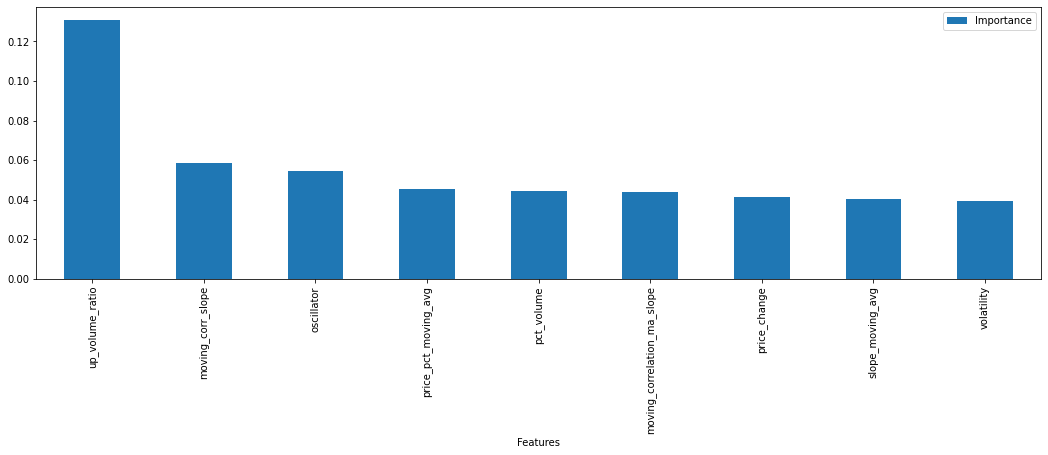

In [10]:
# Declaring X and y for the Machine Learning
nvda = pd.read_csv(nvda_txt, sep=',',parse_dates = True, infer_datetime_format= True)
feature_cols = ['price_change', 'volatility', 'up_volume_ratio', 'pct_volume', 'oscillator', 'slope_moving_avg', 'moving_correlation_ma_slope', 'moving_corr_slope', 'price_pct_moving_avg']
nvda = algo_features(nvda)
nvda_df = nvda.new_dataset
#nvda_df.reset_index(drop = True, inplace = True)
X = nvda_df[feature_cols]
y = nvda_df.target_signal

# Running Machine Learning Algorithems
tree = decision_tree(X, y) # To Apply Decision Tree Algo
tree_1 = decision_tree_dept(X, y) # To Apply Decision Tree Algo with Optimization
tree.importance_features(X, y) # To verify the important features within the dataset

In [11]:
# Zipping y_pred values to the original dataset to calculate profit

# Slicing the original dataset
split = split = int(.7 * len(nvda_df))
nvda_test = nvda_df[split:]

# Turning array into list
lst_1 = []
for i in tree_1.y_pred:
  lst_1.append(i)

# Creating the prediction values column
nvda_test['Prediction'] = lst_1

# Declaring initial investment
initial_investment = 10000

# Slicing the data to calculate profit after Transaction cost
nvda_test['Return'] = np.where(nvda_test['Prediction'] == 1, 1 * nvda_test['pct_change'], -1 * nvda_test['pct_change'])
nvda_pl_yr = nvda_test['2020-10-22':'2021-10-21']
nvda_pl_yr['Return_$'] = initial_investment * nvda_test['Return']
nvda_pl_yr['Return_$_trx_cost'] = (initial_investment * nvda_test['Return']) - 10
nvda_pl_yr['cummulative_return'] =  nvda_pl_yr['Return'].cumsum()
nvda_pl_yr['cummulative_return_$'] = nvda_pl_yr['cummulative_return'] * initial_investment

# Printing Result/Outcome
print(nvda_pl_yr['Prediction'].value_counts())
print('Total number of Transactions:', len(nvda_pl_yr))
print('Total Transaction cost per trade: $', str(len(nvda_pl_yr)*10))
print('Profit before transaction: $',nvda_pl_yr['Return_$'].sum())
print('Profit after Trx Cost: $', str(nvda_pl_yr['Return_$_trx_cost'].sum()))
nvda_pl_yr.tail()
# nvda_pl_yr.to_excel('/content/drive/MyDrive/excel_test.xlsx', header=True)

1    1792
0    1481
Name: Prediction, dtype: int64
Total number of Transactions: 3273
Total Transaction cost per trade: $ 32730
Profit before transaction: $ 72654.38588692417
Profit after Trx Cost: $ 39924.38588692417


,Open,pct_change,price_change,volatility,up_volume_ratio,pct_volume,oscillator,slope_moving_avg,moving_correlation_ma_slope,moving_corr_slope,price_pct_moving_avg,target_signal,Prediction,Return,Return_$,Return_$_trx_cost,cummulative_return,cummulative_return_$
Date_time,,,,,,,,,,,,,,,,,,
2021-10-21 11:30:00,224.94,0.003512,0.66,0.003554,0.560110,0.768422,0.863406,0.000576,-0.241600,0.005695,1.011025,1,1,0.003512,35.120477,25.120477,7.261015,72610.152716
2021-10-21 12:00:00,225.73,0.002525,0.79,0.003566,0.611804,1.045602,0.905054,0.000644,-0.239319,0.002282,1.013923,1,1,0.002525,25.251407,15.251407,7.263540,72635.404122
2021-10-21 12:30:00,226.30,-0.001591,0.57,0.003587,0.470109,0.574310,0.992343,0.000674,-0.248143,-0.008824,1.015799,0,0,0.001591,15.908087,5.908087,7.265131,72651.312209
2021-10-21 13:00:00,225.94,-0.001726,-0.36,0.003458,0.487705,0.529794,0.937213,0.000624,-0.288404,-0.040261,1.013550,0,0,0.001726,17.261220,7.261220,7.266857,72668.573428
2021-10-21 13:30:00,225.55,0.001419,-0.39,0.003463,0.493732,0.530252,0.877489,0.000363,-0.291445,-0.003041,1.011433,1,0,-0.001419,-14.187542,-24.187542,7.265439,72654.385887


max_depth:  3
max_sample_leaf:  2


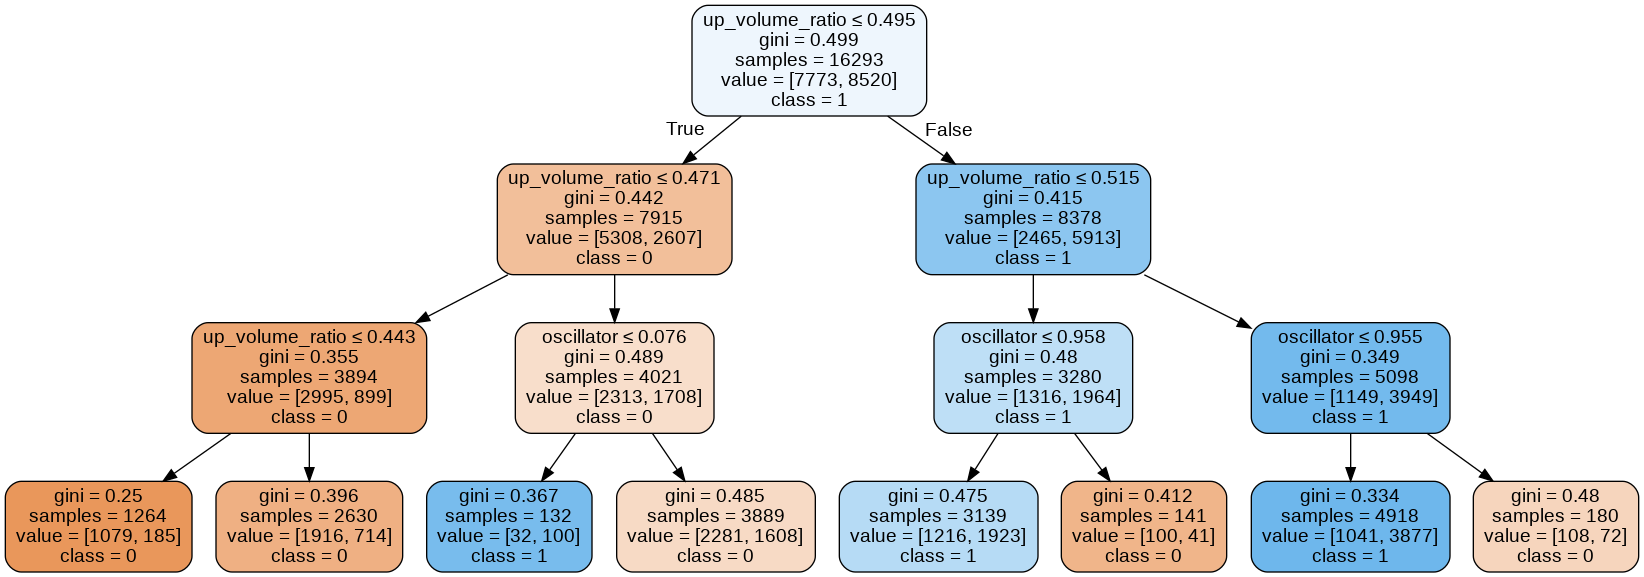

In [12]:
# Visualizing using graphviz function
class decision_tree_visualization(decision_algo):
  def __init__(self):
    c = decision_algo(X, y)
    self.abc = c.abc
    print('max_depth: ', self.abc.best_params_['max_depth'])
    print('max_sample_leaf: ', self.abc.best_params_['min_samples_leaf'])
    dot_data = StringIO()
    clf = DecisionTreeClassifier(max_depth=self.abc.best_params_['max_depth'],min_samples_leaf=self.abc.best_params_['min_samples_leaf'])
    clf.fit(X, y)
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = feature_cols,class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('algo.png')
    self.im = Image(graph.create_png())
    

visual = decision_tree_visualization()
visual.im

## Application of Decision Tree ML on a Quantiles basis taken as Target Signal

In [13]:
# Updating Quantiles as a Target for our Dataset to be applied on the Machine Learning Algo
class multi_signal(algo_features, decision_tree_dept):
  def __init__(self, dataset, rolling_window=1, quant = 1):
    b = algo_features(dataset, rolling_window)
    self.dataset = b.new_dataset
    
    # for quant in window:
    self.dataset['MultiClassSignal']= pd.qcut(self.dataset['pct_change'],q = quant, labels = False)
    self.multi_dataset = self.dataset[['pct_change', 'price_change', 'volatility', 'up_volume_ratio', 'pct_volume', 'oscillator', 'slope_moving_avg', 'moving_correlation_ma_slope', 'moving_corr_slope', 'price_pct_moving_avg', 'MultiClassSignal']]
    self.multi_dataset.reset_index(drop = True, inplace = True) 
    features_cols = ['pct_change', 'price_change', 'volatility', 'up_volume_ratio', 'pct_volume', 'oscillator', 'slope_moving_avg', 'moving_correlation_ma_slope', 'moving_corr_slope', 'price_pct_moving_avg']

    self.X = self.multi_dataset[feature_cols]
    self.y = self.multi_dataset.MultiClassSignal

    c = decision_tree_dept(self.X, self.y)
    self.y_pred = c.y_pred
    self.y_test = c.y_test
    print(f'Quantiles: {quant}')

    #Calling Classification function within decision_algo class
    classification = classification_report(self.y_pred, self.y_test, output_dict = True)
    classification_df = pd.DataFrame(classification).transpose() # if this line of code is removed the data will appear as dictionary
    print(classification_df)

    # # Calling Importance function within decision_algo class
    tree = decision_algo(self.X, self.y)
    tree.importance_features(self.X, self.y)


............................
Optimizing Decision Tree
max_depth:  3
max_sample_leaf:  2
Accuracy: 0.6923076923076923
Quantiles: 2
              precision    recall  f1-score      support
0              0.570021  0.752304  0.648598  1845.000000
1              0.813698  0.655932  0.726346  3043.000000
accuracy       0.692308  0.692308  0.692308     0.692308
macro avg      0.691859  0.704118  0.687472  4888.000000
weighted avg   0.721720  0.692308  0.697000  4888.000000
............................
Importance Feature


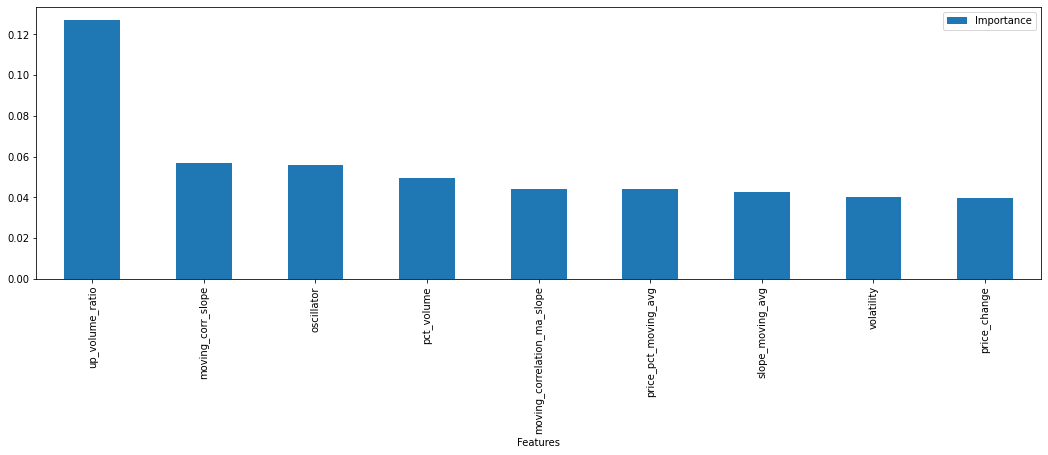

............................
Optimizing Decision Tree
max_depth:  3
max_sample_leaf:  2
Accuracy: 0.523936170212766
Quantiles: 3
              precision    recall  f1-score      support
0              0.531307  0.588552  0.558466  1485.000000
1              0.581274  0.443013  0.502812  2018.000000
2              0.465103  0.572563  0.513269  1385.000000
accuracy       0.523936  0.523936  0.523936     0.523936
macro avg      0.525895  0.534709  0.524849  4888.000000
weighted avg   0.533177  0.523936  0.522683  4888.000000
............................
Importance Feature


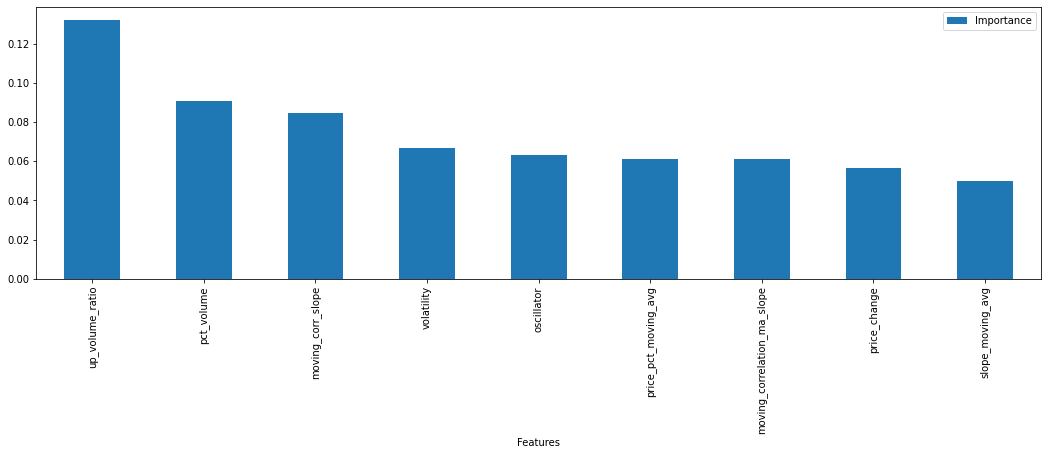

............................
Optimizing Decision Tree
max_depth:  3
max_sample_leaf:  2
Accuracy: 0.4682896890343699
Quantiles: 4
              precision    recall  f1-score     support
0              0.567224  0.508922  0.536494  1401.00000
1              0.188455  0.485777  0.271560   457.00000
2              0.491409  0.384409  0.431373  1488.00000
3              0.606672  0.507134  0.552455  1542.00000
accuracy       0.468290  0.468290  0.468290     0.46829
macro avg      0.463440  0.471560  0.447970  4888.00000
weighted avg   0.521176  0.468290  0.484758  4888.00000
............................
Importance Feature


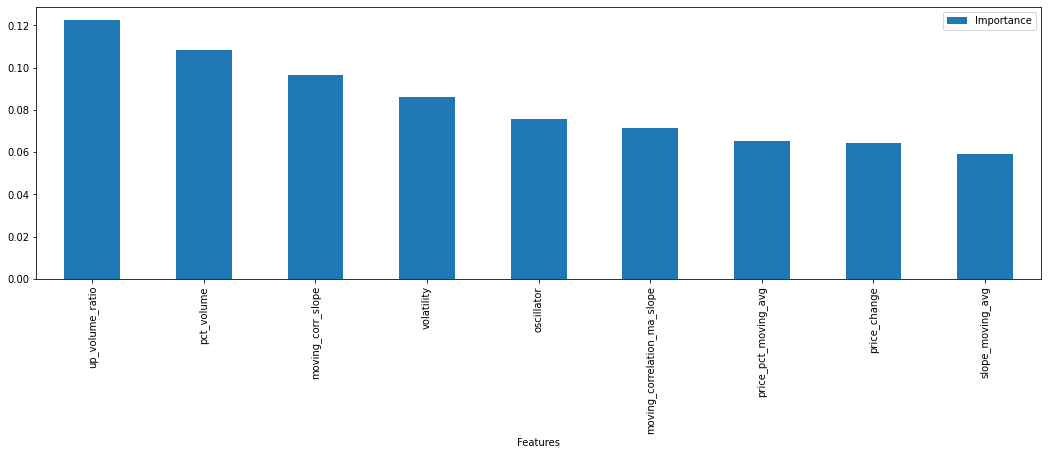

............................
Optimizing Decision Tree
max_depth:  3
max_sample_leaf:  2
Accuracy: 0.3944353518821604
Quantiles: 5
              precision    recall  f1-score      support
0              0.622309  0.412451  0.496100  1542.000000
1              0.256494  0.365741  0.301527   648.000000
2              0.218441  0.335582  0.264628   593.000000
3              0.304563  0.321466  0.312787   955.000000
4              0.536657  0.477391  0.505292  1150.000000
accuracy       0.394435  0.394435  0.394435     0.394435
macro avg      0.387693  0.382526  0.376067  4888.000000
weighted avg   0.442585  0.394435  0.408571  4888.000000
............................
Importance Feature


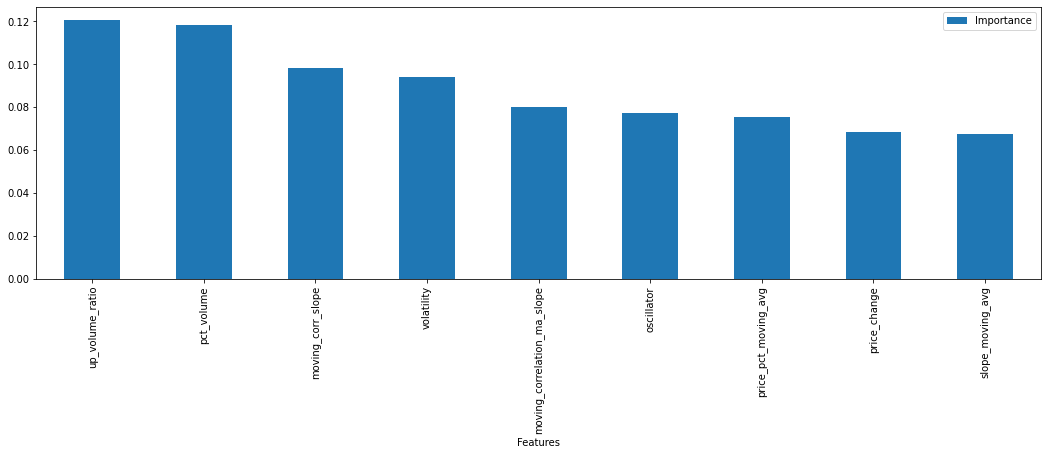

In [14]:
nvda = pd.read_csv(nvda_txt, sep=',',parse_dates = True, infer_datetime_format= True)
# Calling multi_signal class and passing the required arguments
for q in range(2,6): # Ran multiple quantiles to see which one gives the best precision and recall with higher accuracy
  abc = multi_signal(nvda, quant = q )

............................
Optimizing Decision Tree
max_depth:  3
max_sample_leaf:  2
Accuracy: 0.4682896890343699
Quantiles: 4
              precision    recall  f1-score     support
0              0.567224  0.508922  0.536494  1401.00000
1              0.188455  0.485777  0.271560   457.00000
2              0.491409  0.384409  0.431373  1488.00000
3              0.606672  0.507134  0.552455  1542.00000
accuracy       0.468290  0.468290  0.468290     0.46829
macro avg      0.463440  0.471560  0.447970  4888.00000
weighted avg   0.521176  0.468290  0.484758  4888.00000
............................
Importance Feature


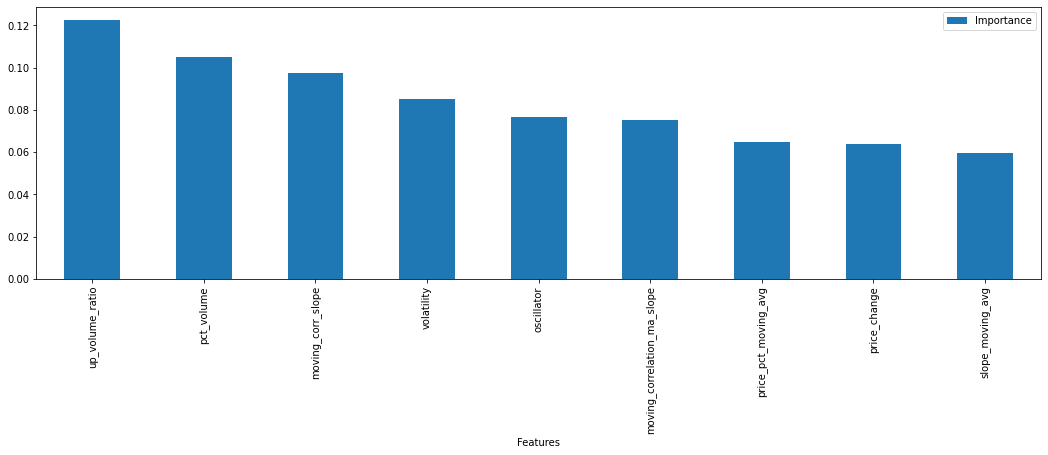

In [15]:
nvda = pd.read_csv(nvda_txt, sep=',',parse_dates = True, infer_datetime_format= True)
# Calling multi_signal class and passing the required arguments
for q in range(4,5): # running the loop again but making sure that the only quantile taken is 4 as from the above example it is clear that 4 quantile will generate the highest profit with minimal trade
  abc = multi_signal(nvda, quant = q )

In [16]:
# Calling the dataset with Quantile = 4 from above
optimi_dataset = abc.dataset

# Slicing the original dataset
split = split = int(.7 * len(optimi_dataset))
optimi_dataset_df = optimi_dataset[split:]

# Turning array into list
lst_2 = []
for i in abc.y_pred:
  lst_2.append(i)

# Creating the prediction values column
optimi_dataset_df['Prediction'] = lst_2

# creating function to only estimate profit based on the classification metric report above
# according to the algo the highest profit with minimal trades can be taken where we go short on quantile 0 and long on quantile 3
def high_values(optimi_dataset_df):
  if optimi_dataset_df['Prediction'] == 0:
    return -1 * optimi_dataset_df['pct_change']
  elif optimi_dataset_df['Prediction'] == 3:
    return 1 * optimi_dataset_df['pct_change']
  else:
    return 0

def tx_cost(optimi_dataset_df_yr):
  a = [0, 3]
  if optimi_dataset_df_yr['Prediction'] in a:
    return (initial_investment * optimi_dataset_df_yr['Return']) - 10
  else:
    return 0

# Declaring initial investment
initial_investment = 10000

optimi_dataset_df['Return'] = optimi_dataset_df.apply(high_values, axis = 1)
optimi_dataset_df_yr = optimi_dataset_df['2020-10-22':'2021-10-21']
optimi_dataset_df_yr['Return_$'] = initial_investment * optimi_dataset_df_yr['Return']
optimi_dataset_df_yr['Return_$_tx_cost'] = optimi_dataset_df_yr.apply(tx_cost, axis = 1)
optimi_dataset_df_yr['cummulative_return'] =  optimi_dataset_df_yr['Return'].cumsum()
optimi_dataset_df_yr['cummulative_return_$'] = optimi_dataset_df_yr['cummulative_return'] * initial_investment
# nvda_pl_yr['Return'].sum()*initial_investment*100

# Printing Result/Outcome
print(optimi_dataset_df_yr['Prediction'].value_counts())
print('Total number of transactions: ', str(int((optimi_dataset_df_yr['Return_$'].sum()-optimi_dataset_df_yr['Return_$_tx_cost'].sum())/10)))
print('Transaction Cost: $', str(optimi_dataset_df_yr['Return_$'].sum()-optimi_dataset_df_yr['Return_$_tx_cost'].sum()))
print('Profit before Trx Cost: $', optimi_dataset_df_yr['Return_$'].sum())
print('Profit after Trx Cost: $', str(optimi_dataset_df_yr['Return_$_tx_cost'].sum()))
optimi_dataset_df_yr.tail()

2    1033
3     997
0     888
1     355
Name: Prediction, dtype: int64
Total number of transactions:  1885
Transaction Cost: $ 18850.0
Profit before Trx Cost: $ 53469.833137807684
Profit after Trx Cost: $ 34619.833137807684


,Open,pct_change,price_change,volatility,up_volume_ratio,pct_volume,oscillator,slope_moving_avg,moving_correlation_ma_slope,moving_corr_slope,price_pct_moving_avg,target_signal,MultiClassSignal,Prediction,Return,Return_$,Return_$_tx_cost,cummulative_return,cummulative_return_$
Date_time,,,,,,,,,,,,,,,,,,,
2021-10-21 11:30:00,224.94,0.003512,0.66,0.003554,0.560110,0.768422,0.863406,0.000576,-0.241600,0.005695,1.011025,1,3,2,0.000000,0.000000,0.000000,5.344458,53444.581731
2021-10-21 12:00:00,225.73,0.002525,0.79,0.003566,0.611804,1.045602,0.905054,0.000644,-0.239319,0.002282,1.013923,1,2,3,0.002525,25.251407,15.251407,5.346983,53469.833138
2021-10-21 12:30:00,226.30,-0.001591,0.57,0.003587,0.470109,0.574310,0.992343,0.000674,-0.248143,-0.008824,1.015799,0,1,1,0.000000,0.000000,0.000000,5.346983,53469.833138
2021-10-21 13:00:00,225.94,-0.001726,-0.36,0.003458,0.487705,0.529794,0.937213,0.000624,-0.288404,-0.040261,1.013550,0,1,1,0.000000,0.000000,0.000000,5.346983,53469.833138
2021-10-21 13:30:00,225.55,0.001419,-0.39,0.003463,0.493732,0.530252,0.877489,0.000363,-0.291445,-0.003041,1.011433,1,2,2,0.000000,0.000000,0.000000,5.346983,53469.833138


# Logistic Regression Machine Learning ALgo

In [17]:
class Logistic_regression(algo_features):
  def __init__(self, dataset, win_loop):
    a = algo_features(dataset)
    self.old_dataset = a.new_dataset
    #self.new_dataset = a.new_dataset
    self.new_dataset = a.new_dataset.reset_index(drop = True)
    self.new_dataset['Quantiles'] = pd.qcut(self.new_dataset['pct_change'],q = win_loop, labels = False)
    self.new_dataset_1 = self.new_dataset
    

    CompleteList=[]
    SampledList=[]

    #col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age']
    Allcol_names = list(self.new_dataset_1.columns)
    target_col = ['target_signal', 'Open', 'pct_change', 'Quantiles']
    col_names = [x for x in Allcol_names if x not in target_col]

    #stuff = range(20)
    for L in range(0, len(col_names)+1):
        for subset in itertools.combinations(col_names, L):
            if len(subset)>=2:
                CompleteList.append(subset)
            
    dctResults={'Features':[],'TrainingAccuracy':[],'TrainingPrecision':[],'TrainingRecall':[],
                'TestAccuracy':[],'TestPrecision':[],'TestRecall':[]}

    SampledList = random.sample(CompleteList, k=int(len(CompleteList)/2))

    for sample in SampledList:
        lst=[]
        for entry in sample:
            lst.append(entry)

            col_names = lst
    
        dctResults['Features'].append(sample)
        
        feature_cols = col_names
        X = self.new_dataset_1[feature_cols] # Features
        y = self.new_dataset_1.Quantiles # Target variable
        
        split = int(.7 * len(X))
        self.X_train = X[:split - 1]
        self.X_test = X[split:]
        self.y_train = y[:split - 1]
        self.y_test = y[split:]
        # instantiate the model (using the default parameters)
        logreg = LogisticRegression( multi_class='multinomial', solver='lbfgs')
        
        # fit the model with data
        logreg.fit(self.X_train,self.y_train)
        
        #
        y_pred_train=logreg.predict(self.X_train)
        y_pred_test=logreg.predict(self.X_test)
        
        #cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
        ##cnf_matrix
        dctResults['TrainingAccuracy'].append(metrics.accuracy_score(self.y_train, y_pred_train))
        dctResults['TestAccuracy'].append(metrics.accuracy_score(self.y_test, y_pred_test))
        
        dctResults['TrainingPrecision'].append(metrics.precision_score(self.y_train, y_pred_train, average = 'weighted'))
        dctResults['TestPrecision'].append(metrics.precision_score(self.y_test, y_pred_test, average = 'weighted'))
        
        dctResults['TrainingRecall'].append(metrics.recall_score(self.y_train, y_pred_train, average = 'weighted'))
        dctResults['TestRecall'].append(metrics.recall_score(self.y_test, y_pred_test, average = 'weighted'))
        
    self.dfResult_df=pd.DataFrame(dctResults)
    self.dfResult_df['PrecisionDiff'] = abs(self.dfResult_df['TrainingPrecision'] - self.dfResult_df['TestPrecision'])

class log_sort_data(Logistic_regression):
  def __init__(self, dataset, win_loop):      
    a = Logistic_regression(dataset, win_loop)
    self.new_dataset = a.new_dataset_1
    self.dfResult_df = a.dfResult_df

    self.sorted_df = self.dfResult_df.sort_values(['PrecisionDiff'], ascending = True)
    self.selected_df = self.sorted_df[:10]
    self.final_df = self.selected_df[self.selected_df['TestPrecision']==self.selected_df['TestPrecision'].max()]
    self.final_df_1 = self.final_df[0:1]

    self.new_feat_cols = []
    for i in self.final_df_1['Features']:
      for s in i:
        self.new_feat_cols.append(s)

class logistic_ml(log_sort_data, Logistic_regression):
  def __init__(self, dataset, win_loop):
    a = log_sort_data(dataset, win_loop)
    self.feat_cols = a.new_feat_cols
    self.new_dataset = a.new_dataset
    self.selected_df = a.selected_df
    self.final_df = a.final_df
    self.final_df_1 = a.final_df_1

    self.X = self.new_dataset[self.feat_cols] # Features
    self.y = self.new_dataset.Quantiles # Target variable
    
    split = int(.7 * len(self.X))
    self.X_train = self.X[:split - 1]
    self.X_test = self.X[split:]
    self.y_train = self.y[:split - 1]
    self.y_test = self.y[split:]

      # Create Decision Tree classifer object
    clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')

    # Train Decision Tree Classifer
    clf = clf.fit(self.X_train,self.y_train)

    #Predict the response for test dataset
    self.y_pred = clf.predict(self.X_test)

    # Evaluating Model
    # Model Accuracy, how often is the classifier correct
    self.Accuracy = metrics.accuracy_score(self.y_test, self.y_pred)
    classification = classification_report(self.y_pred, self.y_test)#, output_dict = True)
    #classification_df_new = pd.DataFrame(classification).transpose() # if this line of code is removed the data will appear as dictionary
    print(classification)
    #print("Accuracy:",metrics.accuracy_score(self.y_test, y_pred))

  def importance_features(self):
    clf = LogisticRegression()
    clf.fit(self.X, self.y)

    importance = clf.coef_[0] # Creates an array
    # summarize feature importance
    imp_features = []
    for i,v in enumerate(importance):
      imp_features.append(v)
      #print('Feature: %0d, Score: %.5f' % (i,v))
    importance = list(zip(self.feat_cols, imp_features))
    importance_df = pd.DataFrame(importance, columns = ['Features', 'Importance']) # Convert zipped list to dataframe
    importance_df.sort_values(by = 'Importance', ascending = True, inplace = False)

    print('............................')
    print('Importance Feature')

    importance_df.plot(kind='bar',figsize=(18,5), x = 'Features', y = 'Importance')

    plt.show()
    importance_df
    # pyplot.bar([x for x in range(len(importance))], importance)


### **Logistic Regression Machine Learning Application**

Ran Logistic regression with different Quantiles to see which one predicts with higher accuracy, precision and recall

Quantiles:  2
...........................
              precision    recall  f1-score   support

           0       0.60      0.52      0.56      2802
           1       0.46      0.54      0.49      2086

    accuracy                           0.53      4888
   macro avg       0.53      0.53      0.53      4888
weighted avg       0.54      0.53      0.53      4888

Logistic Regression Machine Learning
Accuracy:  0.5292553191489362
...........................
Feature Columns: ['price_change', 'pct_volume', 'oscillator', 'slope_moving_avg', 'price_pct_moving_avg']
............................
Importance Feature


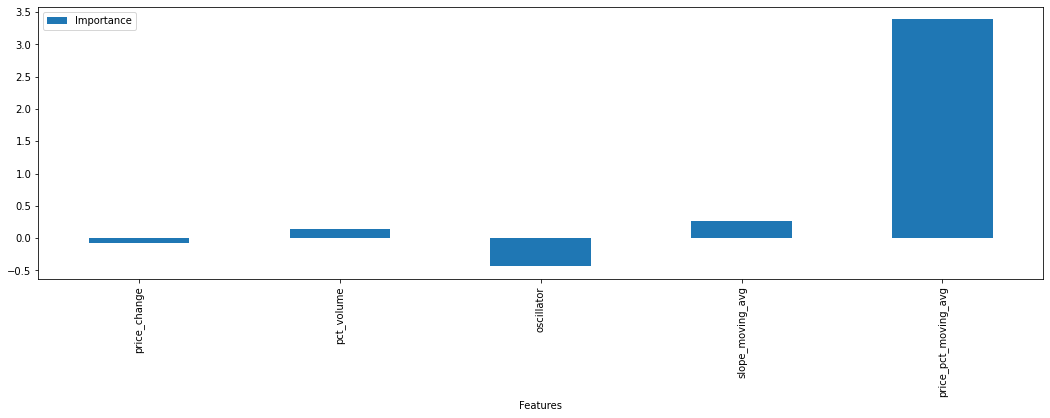

...........................
Precision selected from the dataframe
Quantiles:  3
...........................
              precision    recall  f1-score   support

           0       0.45      0.60      0.51      1227
           1       0.64      0.46      0.53      2144
           2       0.54      0.61      0.57      1517

    accuracy                           0.54      4888
   macro avg       0.54      0.55      0.54      4888
weighted avg       0.56      0.54      0.54      4888

Logistic Regression Machine Learning
Accuracy:  0.5394844517184942
...........................
Feature Columns: ['price_change', 'volatility', 'up_volume_ratio', 'pct_volume', 'moving_corr_slope', 'price_pct_moving_avg']
............................
Importance Feature


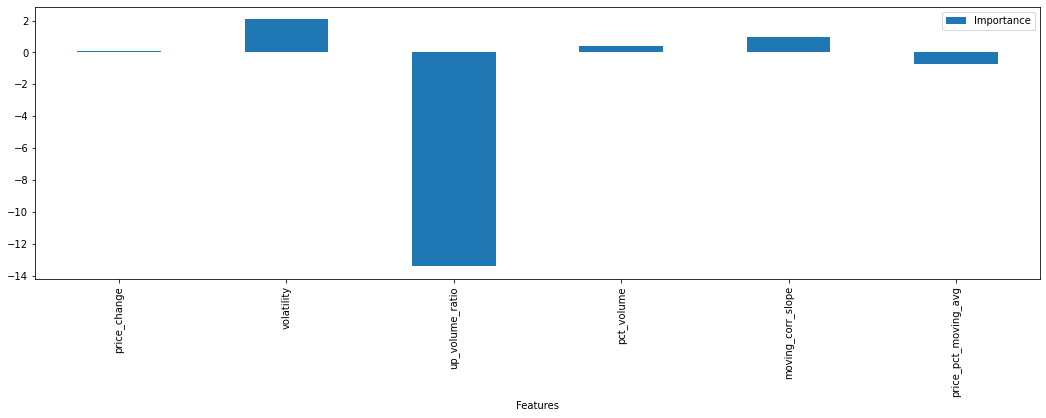

...........................
Precision selected from the dataframe
Quantiles:  4
...........................
              precision    recall  f1-score   support

           0       0.20      0.34      0.25       748
           1       0.61      0.34      0.44      2074
           2       0.25      0.30      0.27       970
           3       0.33      0.39      0.35      1096

    accuracy                           0.34      4888
   macro avg       0.35      0.34      0.33      4888
weighted avg       0.41      0.34      0.36      4888

Logistic Regression Machine Learning
Accuracy:  0.3443126022913257
...........................
Feature Columns: ['price_change', 'volatility', 'pct_volume', 'oscillator', 'moving_correlation_ma_slope', 'moving_corr_slope', 'price_pct_moving_avg']
............................
Importance Feature


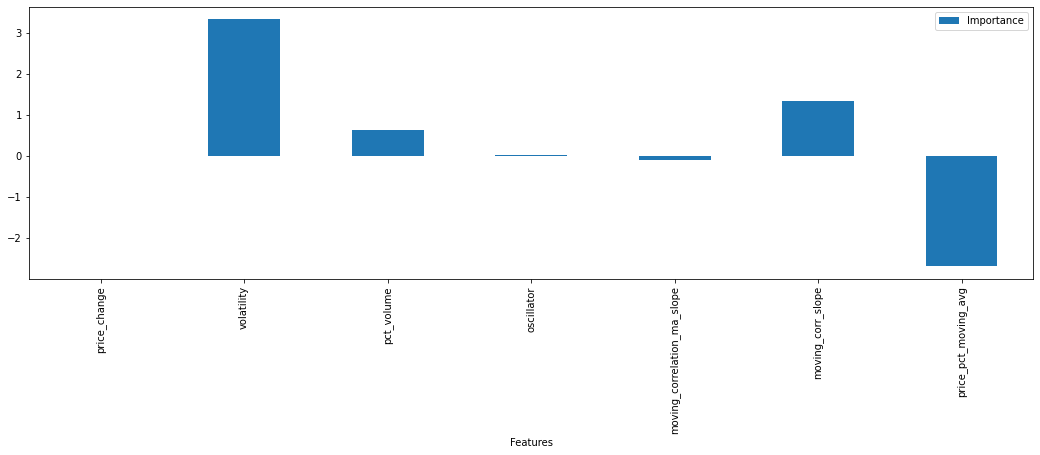

...........................
Precision selected from the dataframe
Quantiles:  5
...........................
              precision    recall  f1-score   support

           0       0.36      0.49      0.41       741
           1       0.37      0.32      0.34      1053
           2       0.44      0.32      0.37      1249
           3       0.31      0.36      0.33       865
           4       0.47      0.49      0.48       980

    accuracy                           0.39      4888
   macro avg       0.39      0.40      0.39      4888
weighted avg       0.39      0.39      0.39      4888

Logistic Regression Machine Learning
Accuracy:  0.3872749590834697
...........................
Feature Columns: ['price_change', 'volatility', 'up_volume_ratio', 'pct_volume', 'oscillator', 'slope_moving_avg', 'moving_correlation_ma_slope', 'price_pct_moving_avg']
............................
Importance Feature


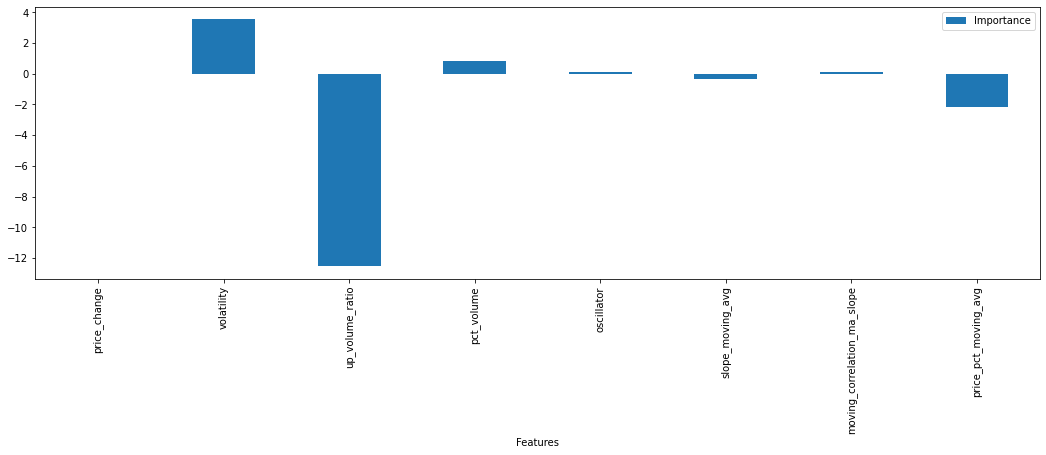

...........................
Precision selected from the dataframe


In [18]:
for win_loop in range(2,6):
  print('Quantiles: ', win_loop)
  print('...........................')
  nvda = pd.read_csv(nvda_txt, sep=',',parse_dates = True, infer_datetime_format= True)
  log_test = logistic_ml(nvda, win_loop)
  print('Logistic Regression Machine Learning')
  print('Accuracy: ',log_test.Accuracy)
  print('...........................')
  print('Feature Columns:', log_test.feat_cols)
  log_test.importance_features()
  print('...........................')
  print('Precision selected from the dataframe')
  log_test.final_df_1